In [2]:
import pandas as pd
import hashlib

In [3]:
#주요 상수값
salt = "MOHW20200925"
DELIMITER = ','
N = 7000000
MATCH = 0.328489271621  

#### 두 기관의 데이터를 불러옵니다.

In [4]:
A_dataset = pd.read_csv("A_dataset.csv", encoding="cp949")
A_dataset.set_index('num')

,field,A0,A1,A2,A3
num,,,,,
A001,33,2,15,5,65
A002,2,23,2,6,8
A003,11,7,44,2,7


In [5]:
B_dataset = pd.read_csv("B_dataset.csv", encoding="UTF-8")
B_dataset.set_index('num')

,field,B0,B1,B2,B3
num,,,,,
B01,2,3,15,45,4
B02,33,6,4,43,2
B03,11,9,7,32,34


#### 데이터 내의 Field 값을 기반으로 sha256으로 암호화 후 저장.
sha256 + salt 방식으로 암호화함

In [6]:
A_dataset['key'] = B_dataset['field'].apply(lambda x : hashlib.sha256(salt.encode() + x.to_bytes(4, byteorder="little")).hexdigest())

#테스트용 ALL data 저장 (테스트용)
A_dataset.to_csv("./ALL/A_dataset_ALL.csv") 

#결합키 + 일련번호 -> 결합키전문기관
#A_dataset[['key','num']].to_csv("./ALL/A_dataset_key.csv") 

#PHI인 Field제외하고 저장 -> 결합전문기관으로 
A_dataset[A_dataset.columns.difference(['field','key'])].to_csv("./ALL/A_dataset_table.csv", index=False) 

In [7]:
B_dataset['key'] = B_dataset['field'].apply(lambda x : hashlib.sha256(salt.encode() + x.to_bytes(4, byteorder="little")).hexdigest())

#테스트용 ALL data 저장 (테스트용)
B_dataset.to_csv("./ALL/B_dataset_ALL.csv")

#결합키 + 일련번호 -> 결합키전문기관
#B_dataset[['key','num']].to_csv("./ALL/B_dataset_key.csv") 

#PHI인 Field제외하고 저장
B_dataset[B_dataset.columns.difference(['field','key'])].to_csv("./ALL/B_dataset_table.csv", index=False)

In [8]:
#결합키 관리기관 -> 결합 키를 기반으로 index 값을 가져옴.
key_idx = pd.merge(A_dataset[['key','num']], B_dataset[['key','num']], left_on='key', right_on='key', how='left')

key_idx[key_idx.columns.difference(['key'])].to_csv("./ALL/index.csv", index=False)


#### HASH키 기반으로 두 데이터 결합하기

In [9]:
#데이터 가져오기
index = pd.read_csv("./ALL/index.csv")

A_dataset_table = pd.read_csv("./ALL/A_dataset_table.csv")
B_dataset_table = pd.read_csv("./ALL/B_dataset_table.csv")

In [10]:
index #결합전문기관에서 수신하는 데이터

,num_x,num_y
0,A001,B01
1,A002,B02
2,A003,B03


In [16]:
join = pd.merge(index, A_dataset_table, left_on='num_x', right_on="num", how='left')

In [17]:
test = pd.merge(join, B_dataset_table, left_on="num_y", right_on="num", how='left')

In [18]:
test

,num_x,num_y,A0,A1,A2,A3,num_x,B0,B1,B2,B3,num_y
0,A001,B01,2,15,5,65,A001,3,15,45,4,B01
1,A002,B02,23,2,6,8,A002,6,4,43,2,B02
2,A003,B03,7,44,2,7,A003,9,7,32,34,B03


In [19]:
test1 = test.iloc[:,:6]

In [20]:
test2 = test.iloc[:,7:-1]

In [21]:
test3 = pd.concat([test1, test2], axis=1)

In [22]:
#결합률 return
def comgLen(dfA, dfB, dfC):
    total = len(dfA) + len(dfB)
    comb = len(dfC)
    return comb / total

In [23]:
comgLen(A_dataset_table, B_dataset_table, test)

0.5

In [24]:
#수치형 자료의 기술 통계만 추출
def static_num(df):
    static = pd.DataFrame(columns = ["기초통계", "평균", "표준편차", "최소", "최대", "왜도", "첨도"])
    #변수의 값들이 숫자인 것들만 뽑아냄
    cols = df.select_dtypes(include="number").columns
    #통계 추출
    static["기초통계"] = cols
    for col in static["기초통계"]:
        static["평균"][static["기초통계"] == col] = df[col].mean()
        static["표준편차"][static["기초통계"] == col] = df[col].std()
        static["최소"][static["기초통계"] == col] = df[col].min()
        static["최대"][static["기초통계"] == col] = df[col].max()
        static["왜도"][static["기초통계"] == col] = df[col].skew()
        static["첨도"][static["기초통계"] == col] = df[col].kurtosis()
    return static

In [25]:
 static_num(test)

,기초통계,평균,표준편차,최소,최대,왜도,첨도
0,A0,10.6667,10.9697,2,23,1.3361,NaN
1,A1,20.3333,21.5019,2,44,1.04751,NaN
2,A2,4.33333,2.08167,2,6,-1.29334,NaN
3,A3,26.6667,33.2014,7,65,1.73028,NaN
4,B0,6,3,3,9,0,NaN
5,B1,8.66667,5.68624,4,15,1.20566,NaN
6,B2,40,7,32,45,-1.57434,NaN
7,B3,13.3333,17.9258,2,34,1.70783,NaN


In [33]:
import matplotlib.pyplot as plt

In [34]:
#확인할 변수명 을 col에 "A011"같이 입력
def one_histogram(df, col): 
    plt.hist(df[col])

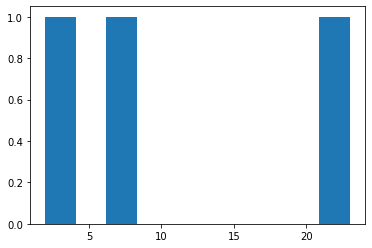

In [38]:
one_histogram(test, "A0")

In [40]:
#하나의 key에 대한 k값만 확인
def kAn(df, id, key): #입력 dataframe, 준식별자의 변수명 ex. df, "id"
    keyLen = len(df[df[id] == key])
    return keyLen

In [85]:
kAn(test3, "num_x", "A001")

1

In [89]:
import numpy as np
from scipy import stats

In [90]:
#두 변수의 공분산, p-value, 상관계수 구함
def cor(df, value1, value2):
    temp = []
    chis = stats.pearsonr(df[value1], df[value2]) #참고 : https://ordo.tistory.com/100
    cov = np.cov(df[value1], df[value2])[0,1] #참고 : https://mindscale.kr/course/basic-stat-python/5/
    temp.append(chis[0]) #temp[0]
    temp.append(chis[1]) #temp[1]
    temp.append(cov)     #temp[2]
    return temp # chis[0]은 상관계수 값, chis[1]은 p-value 값, cov는 공분산 값

In [92]:
cor(test3, 'A0', 'B0')

[0.22790142204853647, 0.8536272099193453, 7.500000000000001]